# <center>Trabajo Práctico N°2 : Criticas Cinematograficas</center>

**Grupo:** N°28 - The Kingdom

**Alumnos**:


*   Jurgens, Cecilia Ines
*   Schipani, Martin Sebastian
*   Soto, Marylin Nicole

**Corrector:** Franco Mastelli

---


In [2]:
!pip install keras==2.12.0
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)


In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import string
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
nltk.download('snowball_data')

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from xgboost import XGBClassifier

from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from scipy.stats import uniform, randint

from nltk.stem.snowball import SpanishStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import joblib

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
!pip install Unidecode

from unidecode import unidecode

# Importacion de los Dataset

## Dataset Train

In [109]:
dataset_train_original = pd.read_csv("/content/drive/MyDrive/Orga Datos - TP2/train.csv")
df_train = dataset_train_original.copy()
df_train.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


Realizamos un pequeño analisis del dataset y sus variables.

In [110]:
df_train.shape

(50000, 3)

In [111]:
df_train.dtypes

ID              int64
review_es      object
sentimiento    object
dtype: object

In [112]:
df_train.sentimiento.value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

In [113]:
df_train.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

## Dataset Test

In [114]:
dataset_test_original = pd.read_csv("/content/drive/MyDrive/Orga Datos - TP2/test.csv")
df_test = dataset_test_original.copy()
df_test.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


Realizamos un pequeño analisis del dataset y sus variables.

In [115]:
df_test.shape

(8599, 2)

In [116]:
df_test.dtypes

ID            int64
review_es    object
dtype: object

In [117]:
df_test.isna().sum()

ID           0
review_es    0
dtype: int64

## Funciones Auxiliares

In [118]:
def imprimir_matriz_confusion(x, y):
  print(classification_report(x, y, digits = 5))
  tabla = confusion_matrix(x, y)
  sns.heatmap(tabla, cmap = 'cubehelix', annot = True, fmt = 'g')
  plt.xlabel('Predicho')
  plt.ylabel('True')

In [119]:
def imprimir_metricas(y1, y2):
  accuracy = accuracy_score(y1, y2)
  recall = recall_score(y1, y2)
  f1 = f1_score(y1, y2)
  precision = precision_score(y1, y2)

  print('Metricas del modelo: ')
  print()
  print("Accuracy: " + str(accuracy))
  print("Recall: " + str(recall))
  print("F1 Score: " + str(f1))
  print("Precision: " + str(precision))

# Preprocesamiento

Primero realizamos una transformacion de la variable sentimiento para poder entrenar a nuestros modelos y realizar las predicciones. Le asignamos variables numericas a esta variable. El valor 'positivo' lo reemplazamos por 1 y el valor 'negativo' por 0.

In [121]:
df_train['sentimiento'] = df_train['sentimiento'].map({'positivo':1, 'negativo': 0})

In [122]:
x_train, x_test, y_train, y_test = train_test_split(df_train['review_es'],
                                                    df_train['sentimiento'],
                                                    test_size = 0.2,
                                                    random_state = 28,
                                                    )

# Red Neuronal

Creamos una red por defecto:

In [141]:
def create_rnn(units = 10, mid_layers = 1, activation = 'relu', learning_rate = 0.001, vectorizer = 'count'):
  nn = keras.Sequential()
  nn.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  vectorize_layer = tf.keras.layers.TextVectorization(output_mode = vectorizer)
  vectorize_layer.adapt(x_train)
  nn.add(vectorize_layer)

  for _ in range(mid_layers):
    nn.add(keras.layers.Dense(units = units, activation = activation))
  nn.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

  nn.compile(loss = 'binary_crossentropy',
             optimizer = keras.optimizers.Nadam(learning_rate = learning_rate),
             metrics = ['accuracy'])
  return nn

In [142]:
nn_default = create_rnn()
nn_default.fit(x_train, y_train, epochs = 3, batch_size = 50, verbose= 3)

Epoch 1/3
Epoch 2/3
Epoch 3/3


In [128]:
y_pred_rnn = nn_default.predict(x_test)

313/313 [==============================] - 6s 18ms/step


              precision    recall  f1-score   support

           0    0.89157   0.86393   0.87753      4968
           1    0.86965   0.89626   0.88276      5032

    accuracy                        0.88020     10000
   macro avg    0.88061   0.88010   0.88014     10000
weighted avg    0.88054   0.88020   0.88016     10000



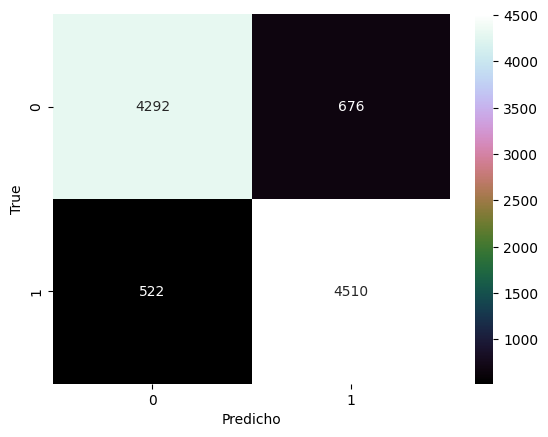

In [144]:
y_pred_rnn = np.round(y_pred_rnn.flatten()).astype(int)
imprimir_matriz_confusion(y_test, y_pred_rnn)

In [145]:
imprimir_metricas(y_test, y_pred_rnn)

Metricas del modelo: 

Accuracy: 0.8802
Recall: 0.8962639109697933
F1 Score: 0.8827559209238598
Precision: 0.8696490551484767


Ahora optimizamos los hiperparamteros de la red neuronal:

In [ ]:
n = 10

params_grid = {
    'units': range(10, 80),
    'mid_layers': [1,2,3,4],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'leaning_rate': [0.01, 0.001, 0.0001],
    'vectorizer': ['count', 'tf_idf'],
    'epochs': range(3, 24),
    'batch_size': range(50, 700)
}

folds= 5
kfoldcv = StratifiedKFold(n_splits = folds)
scorer_fn = make_scorer(f1_score, average= 'weighted')
nn = KerasClassifier(build_fn = create_rnn, verbose = 3)
randomcv = RandomizedSearchCV(estimator = nn, param_distributions= params_grid, cv = kfoldcv, scoring = scorer_fn, n_iter=n, random_state = 28)
randomcv.fit(x_train, y_train)
randomcv.cv_results_['mean_test_score']

Despues de correr la busqueda, hemos encontrado los siguientes hiperparametros:

In [131]:
nn_hiper = create_rnn(units = 44, mid_layers = 2, activation = 'tanh', learning_rate = 0.001, vectorizer = 'count')
nn_hiper.fit(x_train, y_train, epochs = 5, batch_size = 500, verbose = 1)
y_pred_rnn_hiper = nn_hiper.predict(x_test)

Epoch 1/5
80/80 [==============================] - 61s 750ms/step - loss: 0.3682 - accuracy: 0.8405
Epoch 2/5
80/80 [==============================] - 58s 720ms/step - loss: 0.0885 - accuracy: 0.9720
Epoch 3/5
80/80 [==============================] - 58s 716ms/step - loss: 0.0195 - accuracy: 0.9959
Epoch 4/5
80/80 [==============================] - 57s 715ms/step - loss: 0.0041 - accuracy: 0.9995
Epoch 5/5
313/313 [==============================] - 10s 31ms/step


              precision    recall  f1-score   support

           0    0.87655   0.85467   0.86547      4968
           1    0.85997   0.88116   0.87044      5032

    accuracy                        0.86800     10000
   macro avg    0.86826   0.86792   0.86795     10000
weighted avg    0.86821   0.86800   0.86797     10000



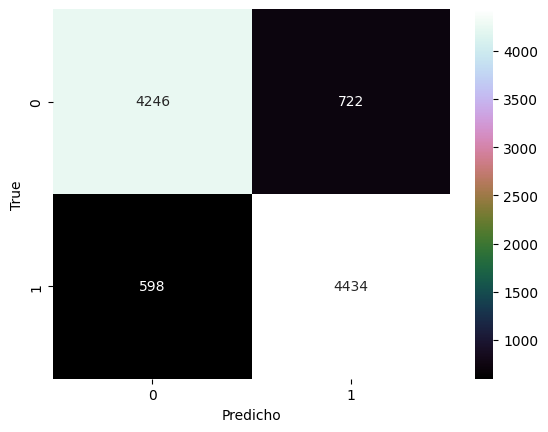

In [146]:
y_pred_rnn_hiper = np.round(y_pred_rnn_hiper.flatten()).astype(int)
imprimir_matriz_confusion(y_test, y_pred_rnn_hiper)

In [137]:
imprimir_metricas(y_test, y_pred_rnn_hiper)

Metricas del modelo: 

Accuracy: 0.868
Recall: 0.8811605723370429
F1 Score: 0.8704358068315665
Precision: 0.8599689681923972
